In [1]:
#!/usr/bin/env python

"""
Usage example employing Lasagne for digit recognition using the MNIST dataset.
This example is deliberately structured as a long flat file, focusing on how
to use Lasagne, instead of focusing on writing maximally modular and reusable
code. It is used as the foundation for the introductory Lasagne tutorial:
http://lasagne.readthedocs.org/en/latest/user/tutorial.html
More in-depth examples and reproductions of paper results are maintained in
a separate repository: https://github.com/Lasagne/Recipes
"""

from __future__ import print_function

import sys
import os
import time

import numpy as np
import theano
import theano.tensor as T

import lasagne


# ################## Download and prepare the MNIST dataset ##################
# This is just some way of getting the MNIST dataset from an online location
# and loading it into numpy arrays. It doesn't involve Lasagne at all.

def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test


# ##################### Build the neural network model #######################
# This script supports three types of models. For each one, we define a
# function that takes a Theano variable representing the input and returns
# the output layer of a neural network model built in Lasagne.

def build_mlp(input_var=None):
    # This creates an MLP of two hidden layers of 800 units each, followed by
    # a softmax output layer of 10 units. It applies 20% dropout to the input
    # data and 50% dropout to the hidden layers.

    # Input layer, specifying the expected input shape of the network
    # (unspecified batchsize, 1 channel, 28 rows and 28 columns) and
    # linking it to the given Theano variable `input_var`, if any:
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                     input_var=input_var)

    # Apply 20% dropout to the input data:
    l_in_drop = lasagne.layers.DropoutLayer(l_in, p=0.2)

    # Add a fully-connected layer of 800 units, using the linear rectifier, and
    # initializing weights with Glorot's scheme (which is the default anyway):
    l_hid1 = lasagne.layers.DenseLayer(
            l_in_drop, num_units=800,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())

    # We'll now add dropout of 50%:
    l_hid1_drop = lasagne.layers.DropoutLayer(l_hid1, p=0.5)

    # Another 800-unit layer:
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1_drop, num_units=800,
            nonlinearity=lasagne.nonlinearities.rectify)

    # 50% dropout again:
    l_hid2_drop = lasagne.layers.DropoutLayer(l_hid2, p=0.5)

    # Finally, we'll add the fully-connected output layer, of 10 softmax units:
    l_out = lasagne.layers.DenseLayer(
            l_hid2_drop, num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)

    # Each layer is linked to its incoming layer(s), so we only need to pass
    # the output layer to give access to a network in Lasagne:
    return l_out


def build_custom_mlp(input_var=None, depth=2, width=800, drop_input=.2,
                     drop_hidden=.5):
    # By default, this creates the same network as `build_mlp`, but it can be
    # customized with respect to the number and size of hidden layers. This
    # mostly showcases how creating a network in Python code can be a lot more
    # flexible than a configuration file. Note that to make the code easier,
    # all the layers are just called `network` -- there is no need to give them
    # different names if all we return is the last one we created anyway; we
    # just used different names above for clarity.

    # Input layer and dropout (with shortcut `dropout` for `DropoutLayer`):
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                        input_var=input_var)
    if drop_input:
        network = lasagne.layers.dropout(network, p=drop_input)
    # Hidden layers and dropout:
    nonlin = lasagne.nonlinearities.rectify
    for _ in range(depth):
        network = lasagne.layers.DenseLayer(
                network, width, nonlinearity=nonlin)
        if drop_hidden:
            network = lasagne.layers.dropout(network, p=drop_hidden)
    # Output layer:
    softmax = lasagne.nonlinearities.softmax
    network = lasagne.layers.DenseLayer(network, 10, nonlinearity=softmax)
    return network


def build_cnn(input_var=None):
    # As a third model, we'll create a CNN of two convolution + pooling stages
    # and a fully-connected hidden layer in front of the output layer.

    # Input layer, as usual:
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                        input_var=input_var)
    # This time we do not apply input dropout, as it tends to work less well
    # for convolutional layers.

    # Convolutional layer with 32 kernels of size 5x5. Strided and padded
    # convolutions are supported as well; see the docstring.
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    # Expert note: Lasagne provides alternative convolutional layers that
    # override Theano's choice of which implementation to use; for details
    # please see http://lasagne.readthedocs.org/en/latest/user/tutorial.html.

    # Max-pooling layer of factor 2 in both dimensions:
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # Another convolution with 32 5x5 kernels, and another 2x2 pooling:
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # A fully-connected layer of 256 units with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=256,
            nonlinearity=lasagne.nonlinearities.rectify)

    # And, finally, the 10-unit output layer with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)

    return network


# ############################# Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


# ############################## Main program ################################
# Everything else will be handled in our main program now. We could pull out
# more functions to better separate the code, but it wouldn't make it any
# easier to read.

def main(model='mlp', num_epochs=500):
    # Load the dataset
    print("Loading data...")
    X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

    # Prepare Theano variables for inputs and targets
    input_var = T.tensor4('inputs')
    target_var = T.ivector('targets')

    # Create neural network model (depending on first command line parameter)
    print("Building model and compiling functions...")
    if model == 'mlp':
        network = build_mlp(input_var)
    elif model.startswith('custom_mlp:'):
        depth, width, drop_in, drop_hid = model.split(':', 1)[1].split(',')
        network = build_custom_mlp(input_var, int(depth), int(width),
                                   float(drop_in), float(drop_hid))
    elif model == 'cnn':
        network = build_cnn(input_var)
    else:
        print("Unrecognized model type %r." % model)
        return

    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    loss = loss.mean()
    # We could add some weight decay as well here, see lasagne.regularization.

    # Create update expressions for training, i.e., how to modify the
    # parameters at each training step. Here, we'll use Stochastic Gradient
    # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.01, momentum=0.9)

    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
    test_loss = test_loss.mean()
    # As a bonus, also create an expression for the classification accuracy:
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates)

    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, 500, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, 500, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))

    # After training, we compute and print the test error:
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 500, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))

    # Optionally, you could now dump the network weights to a file like this:
    # np.savez('model.npz', *lasagne.layers.get_all_param_values(network))
    #
    # And load them again later on like this:
    # with np.load('model.npz') as f:
    #     param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    # lasagne.layers.set_all_param_values(network, param_values)


Using gpu device 0: GeForce GTX 980


In [2]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

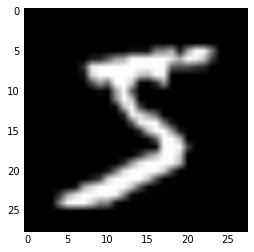

In [8]:
%matplotlib inline
import pylab as plt

plt.imshow(X_train[0].reshape(28,28),cmap='gray')

In [9]:
main()

Loading data...
Building model and compiling functions...
Starting training...
Epoch 1 of 500 took 1.335s
  training loss:		1.248632
  validation loss:		0.418840
  validation accuracy:		88.05 %
Epoch 2 of 500 took 1.298s
  training loss:		0.570568
  validation loss:		0.308021
  validation accuracy:		91.28 %
Epoch 3 of 500 took 1.330s
  training loss:		0.470071
  validation loss:		0.264083
  validation accuracy:		92.45 %
Epoch 4 of 500 took 1.327s
  training loss:		0.419380
  validation loss:		0.235541
  validation accuracy:		93.06 %
Epoch 5 of 500 took 1.309s
  training loss:		0.374315
  validation loss:		0.213803
  validation accuracy:		93.65 %
Epoch 6 of 500 took 1.323s
  training loss:		0.346022
  validation loss:		0.198422
  validation accuracy:		94.16 %
Epoch 7 of 500 took 1.321s
  training loss:		0.319444
  validation loss:		0.181928
  validation accuracy:		94.71 %
Epoch 8 of 500 took 1.442s
  training loss:		0.303070
  validation loss:		0.170790
  validation accuracy:		95.06 %
E